# Testing Hiercal Logistic Regression


## CarDataset

### Preprocessing of the Dataset

In [1]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, Birch
from sklearn.metrics import completeness_score, homogeneity_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import operator
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [2]:
SEED = 1234

DATASET_PATH = os.path.join("datasets", "car.csv")
names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "Classes"]
car = pd.read_csv(DATASET_PATH, delimiter=";", header=0, names=names)
car = car.convert_dtypes()
TARGET_INDEX = car.shape[1] - 1
# dictionary converting ordinal categories to values
cost_dict = {"low": 0, "med": 1, "high": 2, "vhigh": 3}
doors_dict = {"2": 2, "3": 3, "4": 4, "5more": 5}
persons_dict = {"2": 2, "4": 4, "more": 5}
dimension_dict = {"small": 0, "med": 1, "big": 2}
# buying
car["buying"] = car["buying"].apply(lambda x: cost_dict[x])
car["maint"] = car["maint"].apply(lambda x: cost_dict[x])
car["doors"] = car["doors"].apply(lambda x: doors_dict[x])
car["persons"] = car["persons"].apply(lambda x: persons_dict[x])
car["lug_boot"] = car["lug_boot"].apply(lambda x: dimension_dict[x])
car["safety"] = car["safety"].apply(lambda x: cost_dict[x])
car.head(5)

,buying,maint,doors,persons,lug_boot,safety,Classes
0,3,3,2,2,0,0,unacc
1,3,3,2,2,0,1,unacc
2,3,3,2,2,0,2,unacc
3,3,3,2,2,1,0,unacc
4,3,3,2,2,1,1,unacc


Labelling the classes with integers.

In [3]:
classes_encoder = preprocessing.LabelEncoder().fit(car["Classes"])
car["Classes"] = classes_encoder.transform(car["Classes"])
car.head(5)

,buying,maint,doors,persons,lug_boot,safety,Classes
0,3,3,2,2,0,0,2
1,3,3,2,2,0,1,2
2,3,3,2,2,0,2,2
3,3,3,2,2,1,0,2
4,3,3,2,2,1,1,2


Apply last transformation to input and extract targets. Then split the dataset into training and test. Training is done with 1 fold.

In [4]:
#Preprocessing: we get the columns names of features which have to be standardized
feature_names = list(car)[0:-1]

car_features = car[feature_names]
X_std = car_features.copy()
X_std[feature_names] = StandardScaler().fit_transform(car_features)
y = car["Classes"]
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25, random_state=SEED)
df_train = pd.concat([X_train, y_train], axis=1)
classes = y.unique().tolist()
classes.sort() # sorted 
X_train.head(1)

,buying,maint,doors,persons,lug_boot,safety
1710,-1.341641,-1.341641,1.341641,0.267261,-1.224745,-1.224745


Let's visualize class distribution

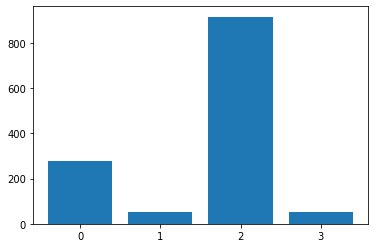

[278, 52, 916, 50]


In [5]:
vals = y_train.unique()
vals.sort()
heights = [len(y_train[y_train==x]) for x in vals ]
vals = [str(x) for x in vals]
plt.bar(vals, heights)
plt.show()
print(heights)

### Hierarchical Logistic Regression
The idea is to pre-train a binary classification tree with the same strcture of the ORCT. Then, the values of the parameters are extracted an passed to the model

In [6]:
from src.cluster import find_best_estimator, best_leaf_assignment, HierarchicalLogisticRegression

First of all we need to find the best estimator. Different clustering algorithms are used. The one that maximizes **homogeneity** is the one chosen. Other metrics can be used, such as **precision**, **purity** and so on. This metrics have all in common the fact that try to maximize the similarity of the points in a cluster. In fact, **homogeneity** is the property that checks how many sample of the same cluster are in the same class.

In [7]:
occurences = [len(y_train[y_train==x]) for x in classes]
total_samples = sum(occurences)
sample_weight = np.zeros_like(y_train)
for class_index, n_occurr in zip(classes, occurences):
    sample_weight[y_train==class_index]=n_occurr
sample_weight = sample_weight/total_samples
    


clustering_estimators = []
params = dict(n_clusters=4, random_state=SEED)
kmeans = KMeans(**params)
clustering_estimators.append(kmeans)

params = dict(n_clusters=4, random_state=SEED, assign_labels="discretize", gamma=1)
spectral = SpectralClustering(**params)
clustering_estimators.append(spectral)

params = dict(n_clusters=4, linkage="single")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=4, linkage="ward")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=4, linkage="complete")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=4, linkage="average")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=4)
birch = Birch(**params)
clustering_estimators.append(birch)

Fit every estimator and computes their homogeneity.

In [8]:
for i in range(len(clustering_estimators)):
    try:
        clustering_estimators[i] = clustering_estimators[i].fit(X_train, sample_weight=sample_weight)
    except:
        clustering_estimators[i] = clustering_estimators[i].fit(X_train)

for estimator in clustering_estimators:
    print(estimator.__class__.__name__, homogeneity_score(y_train, estimator.labels_))
    
best_estimator = find_best_estimator(clustering_estimators, homogeneity_score, y_train)
print("The best estimator is {}".format(best_estimator))

KMeans 0.11250442759726538
SpectralClustering 0.25519657855590033
AgglomerativeClustering 0.17317075945277882
AgglomerativeClustering 0.298780930041104
AgglomerativeClustering 0.2465504369372705
AgglomerativeClustering 0.2364953708934848
Birch 0.25755540689535616
The best estimator is AgglomerativeClustering(n_clusters=4)


/home/oscarpindaro/miniconda3/envs/decision_trees/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  warnings.warn(


Creation of the HLR. The number of leaves must be a power of 2. In this case, since the classes are 4, the leaves will be set to 4. This regressor also needs to know how many classes will encounter.<br> 
Since this classifier is a series of logistic regressors, is also possible to pass the parameters that will be used to inizialized every regressor.
The clustering performed before is used to create multiple clusters that will be assigned to each leaf of the ORCT. In order to find the best assignment, an exhaustive search is done, an the best assingment is found by maximizing the **completeness score**, which measures how much the element of a class are present in the same cluster.

In [9]:
n_leaves = 4
HLR = HierarchicalLogisticRegression(n_classes=len(np.unique(y_train)), n_leaves=n_leaves, prediction_type="deterministic", random_state=0,
                                     logistic_params={"class_weight": "balanced"})
assignment, score = best_leaf_assignment(n_leaves=n_leaves, estimated_labels=best_estimator.labels_, 
                                  true_labels=y_train, metric=completeness_score)
print("The assignment {} has a score of {}".format(assignment, score))

The assignment [0, 1, 2, 3] has a score of 0.27184733468256117


Now it's time to fit the agent. It needs the labels estimater by the clustering and also the assignment of every clustering to each leaves. This model is also able to predict the class of a given sample and can be scored like every other sklearn classifier. <br>
When the classifier is fit, every information about the logistic regressors is computed and is present in the attributes of the HLR

In [10]:
HLR = HLR.fit(X_train, y_train, cluster_labels=estimator.labels_, leaves_assignment=assignment)

In [11]:
score = HLR.score(X_test.to_numpy(), y_test)
print("The mean accuracy is {}".format(score))

The mean accuracy is 0.6805555555555556


In [12]:
HLR.leaf_class_probs_

array([[0.31690141, 0.07981221, 0.52347418, 0.07981221],
       [0.        , 0.        , 1.        , 0.        ],
       [0.11618257, 0.        , 0.88381743, 0.        ],
       [0.52511416, 0.08219178, 0.3196347 , 0.07305936]])

### Model definition

In [13]:
def B_in_NR(model, i):
    if i==4:
        return []
    elif i==5:
        return [2]
    elif i==6:
        return [1]
    elif i==7:
        return [1,3]
def B_in_NL(model, i):
    if i==4:
        return [1,2]
    elif i==5:
        return [1]
    elif i==6:
        return [3]
    elif i==7:
        return []

def I_k(model,i):
    if i==0:
        return I_in_k[0]
    elif i==1:
        return I_in_k[1]
    elif i==2:
        return I_in_k[2]

Objects useful to deal with trees (of depth 2) and their topology

In [14]:
BF_in_NL_R = {4:[],5:[2],6:[1],7:[1,3]}
BF_in_NL_L = {4:[1,2],5:[1],6:[3],7:[]}
I_in_k = {i : list(df_train[df_train['Classes']== i].index) for i in range(len(classes))}
my_W = {(i,j): 0.5 if i != j else 0 for i in classes for j in classes}
index_instances = list(X_train.index)
index_features = range(len(feature_names))
my_x = {(i,j): df_train.loc[i][j] for i in index_instances for j in index_features}

{0: [1429,
  962,
  232,
  418,
  1366,
  878,
  431,
  227,
  1346,
  803,
  1093,
  1507,
  859,
  1312,
  662,
  241,
  373,
  821,
  422,
  376,
  718,
  1153,
  995,
  1183,
  767,
  929,
  286,
  851,
  782,
  862,
  1144,
  566,
  614,
  287,
  1711,
  880,
  428,
  889,
  1064,
  1505,
  290,
  323,
  1558,
  268,
  1612,
  589,
  854,
  800,
  398,
  394,
  646,
  808,
  824,
  1495,
  916,
  1117,
  367,
  260,
  881,
  317,
  917,
  772,
  1147,
  1456,
  1171,
  1345,
  1666,
  590,
  605,
  308,
  1525,
  1172,
  1418,
  725,
  1118,
  742,
  400,
  1048,
  1016,
  1477,
  403,
  1234,
  988,
  779,
  1363,
  592,
  610,
  1321,
  551,
  1388,
  310,
  1510,
  1120,
  1397,
  1402,
  1096,
  292,
  1069,
  1102,
  322,
  971,
  1469,
  283,
  578,
  1498,
  1019,
  1094,
  799,
  833,
  401,
  335,
  1181,
  674,
  320,
  427,
  1370,
  563,
  902,
  1040,
  1474,
  959,
  1225,
  989,
  1073,
  259,
  1415,
  239,
  1049,
  581,
  1343,
  691,
  419,
  421,
  1403,
  341,

We initialize the model and the sets K, N_L, N_B, I, I_k, N_L_L, N_L_R and f_s are declared abstractly using the Set component:

In [15]:
model = ConcreteModel() #ConcretModel()
# Instances & Classes
# Assume a dict I_in_k, with keys k and values of a list of I's in that k

model.I = Set(initialize=set(i for k in I_in_k for i in I_in_k[k]))
model.K = Set(initialize=I_in_k.keys())
model.I_k = Set(model.K,initialize=I_in_k)  # <----- questa linea la ho cambiata se no non mi funzionava

# Features
model.f_s =Set(initialize=index_features)

# Nodes Leaf N_L & Nodes Breanch N_B
model.N_B = Set(initialize=set(i for k in BF_in_NL_R for i in BF_in_NL_R[k]))
model.N_L = Set(initialize=BF_in_NL_R.keys())
model.N_L_R = Set(model.N_L,initialize=B_in_NR)
model.N_L_L = Set(model.N_L,initialize=B_in_NL)

    (type: set).  This WILL potentially lead to nondeterministic behavior in
    Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo


In [16]:
# Cost of misclassification
model.W = Param(model.K, model.K, within=NonNegativeReals, initialize=my_W)

# Value for the instance i-th of the feature j-th
model.x = Param(model.I, model.f_s, within=NonNegativeReals, initialize=my_x) # <--- ho dovuto pure modificare questa linea

ERROR: Rule failed for Param 'x' with index (1710, 0): ValueError: Invalid
    parameter value: x[(1710, 0)] = '-1.3416407864998738', value type=<class
    'numpy.float64'>.
    	Value not in parameter domain NonNegativeReals
ERROR: Constructing component 'x' from data=None failed: ValueError: Invalid
    parameter value: x[(1710, 0)] = '-1.3416407864998738', value type=<class
    'numpy.float64'>.
    	Value not in parameter domain NonNegativeReals


ValueError: Invalid parameter value: x[(1710, 0)] = '-1.3416407864998738', value type=<class 'numpy.float64'>.
	Value not in parameter domain NonNegativeReals

The __Var__ component is used to define the decision variables. No longer a random init is done, but the fitted parameters are assigned.

In [ ]:
#random initialization

init_a = np.random.uniform(low=-1.0, high=1.0, size=None)
init_mu = np.random.uniform(low=-1.0, high=1.0, size=None)
init_C = np.random.uniform(low=0.0, high=1.0, size=None)
init_P = np.random.uniform(low=0.0, high=1.0, size=None)
init_p = np.random.uniform(low=0.0, high=1.0, size=None)


# The weigths of feature j-th in breanch node t-th
model.a = Var(model.f_s, model.N_B, within=Reals, bounds = (-1.0,1.0),initialize=init_a)

# The intercepts of the linear combinations correspond to decision variables
model.mu = Var(model.N_B, within = Reals, bounds = (-1.0,1.0),initialize=init_mu)

# The variables thtat take into account if node t is labeled with class k
model.C = Var(model.K, model.N_L, within = PercentFraction,initialize=init_C)

# An auxiliary variables
model.P = Var(model.I,model.N_L,within = PercentFraction,initialize=init_P)
model.p = Var(model.I,model.N_B,within = PercentFraction,initialize=init_p)

In [ ]:
init_p